In [168]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error,r2_score
import sklearn
from sklearn.model_selection import cross_val_score

In [169]:
# считываем данные
data = pd.read_excel('CityStarExport.xls',skiprows=3, index_col=None,header=1)
data.drop(columns=data.columns[0],inplace=True)
data.head()

,Дата,Адрес,Количество комнат,"Цена, р.",Планировка,Этаж,"Общая площадь, м2","Жилая площадь, м2","Площадь кухни, м2",Дополнительное описание,Контакты,Адрес на сайте
0,07.06.2022 18:19,"Суворова, 114",Однокомнатная,1 450 000,NaN,4/5,"31,60","20,50","6,00",Продаётся просторная и уютная однокомнатная к...,"Каримов Артём Раисович, Рио-Люкс тел. +792269...",http://magnitogorsk-citystar.ru/realty/prodazh...
1,07.06.2022 18:19,"Галиуллина, 49/2",Двухкомнатная,2 450 000,NaN,5/5,"47,90","0,00","6,00","Просторная, светлая квартира ждёт своих новых ...","Гордейчук Евгения Юрьевна, Рио-Люкс тел. +790...",http://magnitogorsk-citystar.ru/realty/prodazh...
2,12.01.2022 16:19,"Ленина пр-т, 112",Двухкомнатная,1 550 000,NaN,9/9,"37,50","29,80","0,00",Удобный вариант двухкомнатной квартиры в центр...,"Клочко Анна Валерьевна, Рио-Люкс тел. +791280...",http://magnitogorsk-citystar.ru/realty/prodazh...
3,31.03.2022 18:19,"50-летия Магнитки, 52",Трехкомнатная,3 050 000,NaN,7/9,"66,00","46,00","9,00",В продаже большая 3-х комнатная квартира улучш...,"Клочко Анна Валерьевна, Рио-Люкс тел. +791280...",http://magnitogorsk-citystar.ru/realty/prodazh...
4,23.05.2022 15:19,"Советская, 149",Двухкомнатная,2 150 000,NaN,3/5,"47,80","0,00","6,00",В Правобережном районе продам 2 комнатную кв...,"Ержанова Моника, Рио-Люкс тел. +79227329445",http://magnitogorsk-citystar.ru/realty/prodazh...


In [170]:
# назначаем колонки
cols = ['date', 'address', 'rooms', 'price', 'planning', 'floor', 'area_total', 'area_living', 'area_kitchen', 'add_info',
        'contacts', 'url']
data.columns=cols

In [171]:
# как называется колонка с кол-вом комнат
data['rooms'].unique()

array(['Однокомнатная', 'Двухкомнатная', 'Трехкомнатная',
       'Четырехкомнатная', 'Многокомнатная', nan], dtype=object)

In [172]:
# меняем текстовое кол-во комнат на числовое, 5 означает 5 и более

In [173]:
data.loc[(data['rooms']=='Однокомнатная'), 'rooms'] = 1
data.loc[(data['rooms']=='Двухкомнатная'), 'rooms'] = 2
data.loc[(data['rooms']=='Трехкомнатная'), 'rooms'] = 3
data.loc[(data['rooms']=='Четырехкомнатная'), 'rooms'] = 4
data.loc[(data['rooms']=='Многокомнатная'), 'rooms'] = 5

In [174]:
# посмотрим где NaN в количестве комнат
data.loc[(data['rooms'].isna()), :]

,date,address,rooms,price,planning,floor,area_total,area_living,area_kitchen,add_info,contacts,url
44,28.05.2022 18:01,"ГСК Зеленый лог территория, 25",NaN,1 170 000,NaN,6/10,"24,00","12,00","6,00",1 комн. квартира по ул. Зеленый Лог. Общей пло...,"Александр Николаевич, ЖИЛФОНД тел. +79068510763",http://magnitogorsk-citystar.ru/realty/prodazh...
45,28.05.2022 18:01,"ГСК Зеленый лог территория, 21",NaN,1 350 000,NaN,1/10,"24,20","12,00","6,00",1 комн. квартира по ул. Зеленый Лог. Общей пло...,"Александр Николаевич, ЖИЛФОНД тел. +79068510763",http://magnitogorsk-citystar.ru/realty/prodazh...
717,19.03.2022 04:42,"ул Астраханская, 33",NaN,6 200 000,NaN,12/17,"33,00","20,00","5,00",Объект №34034 Продается упакованная квартира-с...,"Олег, Панорама тел. (918) 494-06-00",http://magnitogorsk-citystar.ru/realty/prodazh...
914,02.12.2021 05:28,"ул Владимирская, 24",NaN,2 990 000,NaN,-1/20,"25,00","20,00","20,00","Объект №32348 Продается 1-комнатная квартира, ...","Панорама, Панорама тел. (800) 550-55-97",http://magnitogorsk-citystar.ru/realty/prodazh...
1277,02.03.2022 04:12,"Ворошилова, 13",NaN,10 000 000,NaN,4/4,"123,50","40,00","24,00","Продается новая, просторная квартира-студия об...","ОН Перспектива 24 - Горячий Ключ, ОН Перспекти...",http://magnitogorsk-citystar.ru/realty/prodazh...


In [175]:
# это все однокомнатные, поэтому ставим 1
data.loc[(data['rooms'].isna()), 'rooms'] = 1

In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1322 non-null   object
 1   address       1322 non-null   object
 2   rooms         1322 non-null   object
 3   price         1322 non-null   object
 4   planning      586 non-null    object
 5   floor         1322 non-null   object
 6   area_total    1322 non-null   object
 7   area_living   1322 non-null   object
 8   area_kitchen  1322 non-null   object
 9   add_info      1318 non-null   object
 10  contacts      1322 non-null   object
 11  url           1322 non-null   object
dtypes: object(12)
memory usage: 124.1+ KB


In [177]:
# обнаружилось, что продают квартиры в селах, удалю
data.fillna('', inplace=True)
data.drop(data[data['add_info'].str.contains('агапов', case=False)].index,inplace=True)

In [178]:
# в цене уберем пробелы
data['price'] = data['price'].str.replace(u'\xa0', '')

In [179]:
# в площади стоят запятые, будут проблемы с переводом во float
data['area_total'] = data['area_total'].str.replace(',', '.')
data['area_kitchen'] = data['area_kitchen'].str.replace(',', '.')
data['area_living'] = data['area_living'].str.replace(',', '.')
# тут будет сам этаж
data['fl'] = data['floor'].str.split('/',expand=True)[0].astype('int32')
data['fl_tot'] = data['floor'].str.split('/',expand=True)[1]
data.drop(data[data['fl_tot'] == ''].index, inplace=True)

In [180]:
# посмотрим распределение целевой переменной
data['price'] = data['price'].astype('int64')
data['price'].describe(percentiles=[.1,.25,.5,.75,.85,.9,.95,.99])

count    1.314000e+03
mean     2.693844e+06
std      1.423549e+06
min      1.550000e+03
10%      1.550000e+06
25%      1.902500e+06
50%      2.500000e+06
75%      3.100000e+06
85%      3.590000e+06
90%      3.970000e+06
95%      4.735000e+06
99%      7.174000e+06
max      2.729000e+07
Name: price, dtype: float64

In [181]:
# есть несколько очень больших значений
data[data['price']>1e7]

,date,address,rooms,price,planning,floor,area_total,area_living,area_kitchen,add_info,contacts,url,fl,fl_tot
70,24.05.2022 13:19,"Ленина пр-т, 69",1,19500000,,5/5,34.00,19.00,8.00,#объект в нашей базе №12389016#,"Тугузова Алия Амиржановна, Рио-Люкс тел. +790...",http://magnitogorsk-citystar.ru/realty/prodazh...,5,5
161,27.02.2022 12:48,"Ленина пр-т, 57/3",4,10500000,раздельная,2/7,140.00,70.00,18.00,"Продается квартира элит класса, в самом центре...",Александр Сергеевич Конищев тел. 8-909-74-72...,http://magnitogorsk-citystar.ru/realty/prodazh...,2,7
433,20.03.2022 21:01,"Карла Маркса, 56",2,27290000,нестандартная,5/5,41.00,30.00,6.00,ПОКУПАЯ ДАННУЮ КВАРТИРУ ВЫ ПОЛУЧАЕТЕ ПОМОЩЬ В ...,"Лисицкая Вера Васильевна, Корпорация недвижимо...",http://magnitogorsk-citystar.ru/realty/prodazh...,5,5
975,09.06.2021 15:01,"Набережная, 16",5,10700000,нестандартная,2/5,196.00,120.00,25.00,"Пока объект на сайте, значит он в продаже. О ...","Воронов Константин тел. 890-8822-9922,43-02-39",http://magnitogorsk-citystar.ru/realty/prodazh...,2,5


In [182]:
# видно, что несколько из них явно опечатки - маленькие квартиры с огромными ценами = ##70 и 433
data.loc[70,'price'] = data.loc[70,'price']/10
data.loc[433,'price'] = data.loc[433,'price']/10

In [183]:
# и похоже есть несколько очень маленьких значений, возможно тоже ошибки
data[data['price']<1e6]

,date,address,rooms,price,planning,floor,area_total,area_living,area_kitchen,add_info,contacts,url,fl,fl_tot
49,09.05.2022 17:07,"Малиновая, 10/9",2,238191,,1/1,48.60,30.00,8.00,ПАО Сбербанк реализует имущество: \nОбъект (ID...,"Сотрудник ПАО Сбербанк, ПАО Сбербанк тел. +78...",http://magnitogorsk-citystar.ru/realty/prodazh...,1,1
149,06.06.2022 14:19,"Труда, 2",3,650000,,1/2,63.40,0.00,0.00,Продается теплая раздельная трехкомнатная квар...,"Ходжаева Наталья Дмитриевна, Рио-Люкс тел. +7...",http://magnitogorsk-citystar.ru/realty/prodazh...,1,2
186,03.02.2022 16:19,"Первомайский переулок, 13",2,850000,,1/2,50.30,34.00,8.00,Продам 2-ую квартиру 50 кв.м в с. Фершaмпенуaз...,"Климина Наталья Юрьевна, Рио-Люкс тел. +79227...",http://magnitogorsk-citystar.ru/realty/prodazh...,1,2
194,04.08.2021 14:23,"спартаковский перулок, 10/1",1,300000,хрущевка,2/5,34.50,19.00,6.40,продам 1/3 долю квартиры.торг.,"Порпулова Оксана Аркадьевна, Магнитогорский го...",http://magnitogorsk-citystar.ru/realty/prodazh...,2,5
199,28.07.2021 18:41,"Калмыкова, 0",2,950000,хрущевка,1/2,44.00,27.00,6.00,"Дом за Молживом, правобережные очистные сооруж...",nadezdakrasnova1958@mail.ru тел. 89512314452,http://magnitogorsk-citystar.ru/realty/prodazh...,1,2
263,04.08.2021 15:34,"пос. Буранный, ул. Школьная , 66",2,930000,раздельная,1/2,51.00,30.00,9.00,Продам 2х комнатную квартиру в пос. Буранное. ...,Замушинская Ирина Рудольфовна тел. 45-41-45; ...,http://magnitogorsk-citystar.ru/realty/prodazh...,1,2
346,22.03.2022 04:37,"ул. Школьная, 3",2,999000,,2/2,43.10,32.00,6.00,Продам уютную 2-х комнатную квартиру общей пло...,"Вадим Владимирович, Ипотечный сервис тел. 796...",http://magnitogorsk-citystar.ru/realty/prodazh...,2,2
358,29.03.2022 23:04,"Карла Маркса, 64",1,930000,гостиничного типа,2/5,18.30,13.00,2.00,"Однокомнатная квартира Гостиничного типа, на в...",Акулова Ольга тел. +7 912 316 78 09,http://magnitogorsk-citystar.ru/realty/prodazh...,2,5
362,03.06.2022 12:55,"Ленина пр-т, 4-13",2,380000,,2/2,40.00,30.00,6.00,Двухкомнатная квартира в пос. Южный Нагайбакск...,Екатерина тел. 89514787109,http://magnitogorsk-citystar.ru/realty/prodazh...,2,2
401,02.06.2022 14:19,"Ленина пр-т, 112",1,1550,,9/9,38.00,19.00,10.00,ОДНОКОМНАТНОЙ КВАРТИРЫ в центре города на ост....,"Третьякова Диля Викторовна, Рио-Люкс тел. +79...",http://magnitogorsk-citystar.ru/realty/prodazh...,9,9


In [184]:
# три квартиры - цены в тысячах рублей, а не в рублях
data.loc[data['price']<4000, 'price'] *= 1000

In [185]:
#  есть доли, есть квартиры в селах, лучше все их удалить, дешевле 900 т.р.
data.drop(data[data['price']<9e5].index, inplace=True)

In [186]:
data['price'].describe(percentiles=[0.01,0.1,0.5,0.9,0.998])

count    1.304000e+03
mean     2.684083e+06
std      1.144952e+06
min      9.300000e+05
1%       1.101960e+06
10%      1.560000e+06
50%      2.500000e+06
90%      3.967000e+06
99.8%    9.697000e+06
max      1.070000e+07
Name: price, dtype: float64

In [187]:
# поработаем с площадями - может они влияют друг на друга
data['area_total'] = data['area_total'].astype('float')
data['area_kitchen'] = data['area_kitchen'].astype('float')
data['area_living'] = data['area_living'].astype('float')

In [188]:
data.loc[:,data.columns.str.contains('area')].describe()

,area_total,area_living,area_kitchen
count,1304.000000,1304.000000,1304.000000
mean,49.758252,28.328658,7.859233
std,20.012300,17.335246,4.567046
min,4.000000,0.000000,0.000000
25%,35.275000,18.000000,6.000000
50%,45.200000,29.000000,7.000000
75%,61.000000,39.000000,9.000000
max,220.000000,150.000000,50.000000


In [189]:
# общая площадь 4м - так не бывает
data.drop(data[data['area_total']<10].index, inplace=True)

<AxesSubplot:>

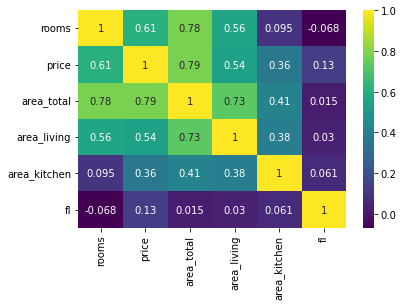

In [190]:
sns.heatmap(data.corr(),annot=True,cmap='viridis')

In [191]:
# отсюда я вижу, что общая площадь и жилая площадь сильно коррелируют

In [192]:
# пробую оставить площадь кухни, для этого удалю везде, где площадь кухни сильно маленькая
data.drop(data[data['area_kitchen']<5].index,inplace=True)

<AxesSubplot:xlabel='area_total', ylabel='price'>

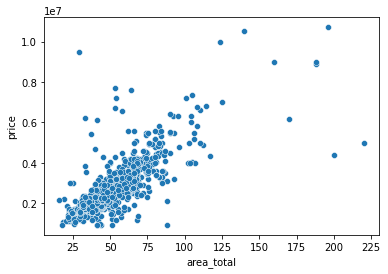

In [193]:
# построю ещё зависимость цены от площади
sns.scatterplot(data=data,x='area_total',y='price')

In [194]:
#некоторые очень большие площади стоят ну как-то мало. может там явные особенные случаи
data[data['area_total']>190]

,date,address,rooms,price,planning,floor,area_total,area_living,area_kitchen,add_info,contacts,url,fl,fl_tot
504,11.01.2022 16:19,"Ленина пр-т, 210 стр.А",5,4400000,,1/1,200.0,100.0,25.0,Выгодное вложение в свой отдых в самом красиво...,"Клочко Анна Валерьевна, Рио-Люкс тел. +791280...",http://magnitogorsk-citystar.ru/realty/prodazh...,1,1
629,11.01.2022 16:21,"Ленина пр-т, 129А",5,5000000,,1/1,220.0,150.0,20.0,"Продам дачу площадью 230 кв метров, находится ...","Намоконов Сергей Анатольевич, Рио-Люкс тел. +...",http://magnitogorsk-citystar.ru/realty/prodazh...,1,1
975,09.06.2021 15:01,"Набережная, 16",5,10700000,нестандартная,2/5,196.0,120.0,25.0,"Пока объект на сайте, значит он в продаже. О ...","Воронов Константин тел. 890-8822-9922,43-02-39",http://magnitogorsk-citystar.ru/realty/prodazh...,2,5


In [195]:
# давайте их удалим - два дома в пригороде
data.drop(data[(data['area_total']>=200) & (data['price']<1e7)].index,inplace=True)

<AxesSubplot:xlabel='area_total', ylabel='price'>

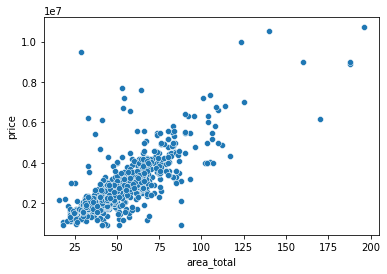

In [196]:
sns.scatterplot(data=data,x='area_total',y='price')
# есть ещё одна странная квартира, которая очень много стоит, но у неё маленькая площадь

In [197]:
data[(data['price']>0.8e7) & (data['area_total']<40)]

,date,address,rooms,price,planning,floor,area_total,area_living,area_kitchen,add_info,contacts,url,fl,fl_tot
312,04.06.2022 18:29,"Армавирская, 20Ак1",1,9500000,нестандартная,3/13,29.0,24.0,12.0,в Сочи в Дагомысе продаётся однокомнатная квар...,Олег тел. 89528575819,http://magnitogorsk-citystar.ru/realty/prodazh...,3,13


In [198]:
# она вообще в Сочи, тоже надо удалить
data.drop(data.index[312], inplace=True)

In [199]:
# Переводим значения в числа
df = data.astype({'rooms':'int32',
                  'area_total':'float',
                  'area_kitchen':'float',
                  'area_living':'float',
                  'price':'float',
                  'fl_tot':'int32'})

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191 entries, 0 to 1321
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1191 non-null   object 
 1   address       1191 non-null   object 
 2   rooms         1191 non-null   int32  
 3   price         1191 non-null   float64
 4   planning      1191 non-null   object 
 5   floor         1191 non-null   object 
 6   area_total    1191 non-null   float64
 7   area_living   1191 non-null   float64
 8   area_kitchen  1191 non-null   float64
 9   add_info      1191 non-null   object 
 10  contacts      1191 non-null   object 
 11  url           1191 non-null   object 
 12  fl            1191 non-null   int32  
 13  fl_tot        1191 non-null   int32  
dtypes: float64(4), int32(3), object(7)
memory usage: 125.6+ KB


In [201]:
# хочу посмотреть, можно ли вытащить район
df['add_info'].str.contains('район').sum()

477

In [202]:
# судя по всему, автоматически вытащить район не выходит, у нас слово "район" встречается в 500 описаниях из 1300

In [203]:
# на сайте youkarta.ru/cheljabinskaja-obl/magnitogorsk-74/ есть возможность вытащить все привязки улиц к районам
# это не на 100% точно, но наверное пойдет

In [204]:
# читаем скачанные файлы и делаем словари
streets_len = pd.read_excel('Magn_streets.xlsx', sheet_name=0,header=None)
streets_ord = pd.read_excel('Magn_streets.xlsx', sheet_name=1,header=None)
streets_prav = pd.read_excel('Magn_streets.xlsx', sheet_name=2,header=None)
# соединю в один словарь
streets = pd.concat([streets_len[0], streets_ord[0], streets_prav[0]]).str.lower()
districts = pd.concat([streets_len[1], streets_ord[1], streets_prav[1]]).str.lower()
dict_streets = dict(zip(streets, districts))

In [205]:
# вытащим улицу
# заодно заменим "проспект", "имени" и "площадь"
df['street'] = df['address'].str.strip().str.lower().str.split(',',expand=True)[0].str.replace('пр-т', 'проспект')
df['street'] = df['street'].str.replace('им ', 'имени') # не знаю, что это за магия но эта строка тут не работает
df['street'] = df['street'].str.replace('пл ', 'площадь ') # не знаю, что это за магия но эта строка тут не работает
# уберем всякие "ул", "улица" "ГСК" и "территория"
df['street'] = df['street'].str.replace('ул ', '') # не знаю, что это за магия но эта строка тут не работает
df['street'] = df['street'].str.replace('улица', '')
df['street'] = df['street'].str.replace('гск', '')
df['street'] = df['street'].str.replace('территория', '')
# удалим лишние пробелы, которые могли образоваться после удаления
df['street'] = df['street'].str.strip()
# удалим всякие символы, которые не являются символьными или пробелами (кавычки точки запятые и т.д.)
df['street'] = df['street'].str.replace('[^a-zA-Z0-9а-яА-Я \-]', '')
# удалим там, где улицы нет
df.drop(df[df['street']==''].index,inplace=True)
# удалю несколько ошибочных названий
df['street'] = df['street'].str.replace('перулок', 'переулок')
df['street'] = df['street'].str.replace('отябрьская', 'октябрьская')
df['street'] = df['street'].str.replace('50 лет', '50-летия')

# последнее подготовительное - удалим все строки, где улицы не совпадают с моим справочником
df.drop(df[~df['street'].isin(list(dict_streets.keys()))].index, inplace=True)

# и наконец добавлю район города
df['district'] = df['street'].apply(lambda x: dict_streets[x])

C:\Users\pheno\AppData\Local\Temp\ipykernel_8880\128435586.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['street'] = df['street'].str.replace('[^a-zA-Z0-9а-яА-Я \-]', '')


In [206]:
# удалим уже ненужные столбцы
df.drop(columns=['date','address','planning', 'add_info', 'contacts', 'url','street','area_living','floor'],
        inplace=True)

In [207]:
# у меня есть идея о том, что в разных районах цены могут быть разными
# давайте проверим

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1157 entries, 0 to 1321
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rooms         1157 non-null   int32  
 1   price         1157 non-null   float64
 2   area_total    1157 non-null   float64
 3   area_kitchen  1157 non-null   float64
 4   fl            1157 non-null   int32  
 5   fl_tot        1157 non-null   int32  
 6   district      1157 non-null   object 
dtypes: float64(3), int32(3), object(1)
memory usage: 58.8+ KB


(0.0, 10000000.0)

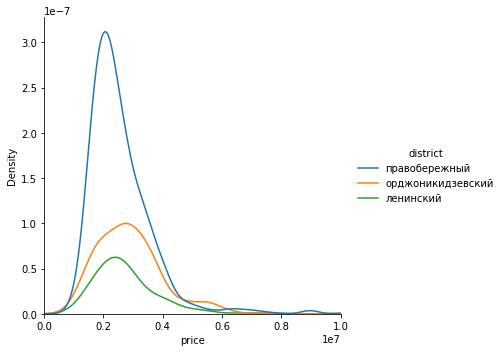

In [209]:
# построю просто распределения цены в зависимости от района города
sns.displot(df, x='price', hue='district',kind='kde')
plt.xlim(0,1e7)

In [210]:
# даже на таком простом графике я вижу, что район имеет значение (распределения разные), поэтому район в модели будет

<AxesSubplot:xlabel='area_total', ylabel='price'>

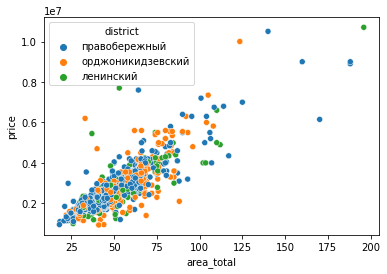

In [211]:
sns.scatterplot(data=df, x='area_total', y='price',hue='district')

In [212]:
# тут вроде все логично выглядит

In [213]:
# сделаем район числовым
districts = {'ленинский':0, 'орджоникидзевский':1, 'правобережный':2}
df['dist'] = df['district'].apply(lambda x: districts[x])
df.drop(columns=['district'],inplace=True)

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1157 entries, 0 to 1321
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rooms         1157 non-null   int32  
 1   price         1157 non-null   float64
 2   area_total    1157 non-null   float64
 3   area_kitchen  1157 non-null   float64
 4   fl            1157 non-null   int32  
 5   fl_tot        1157 non-null   int32  
 6   dist          1157 non-null   int64  
dtypes: float64(3), int32(3), int64(1)
memory usage: 91.0 KB


<AxesSubplot:>

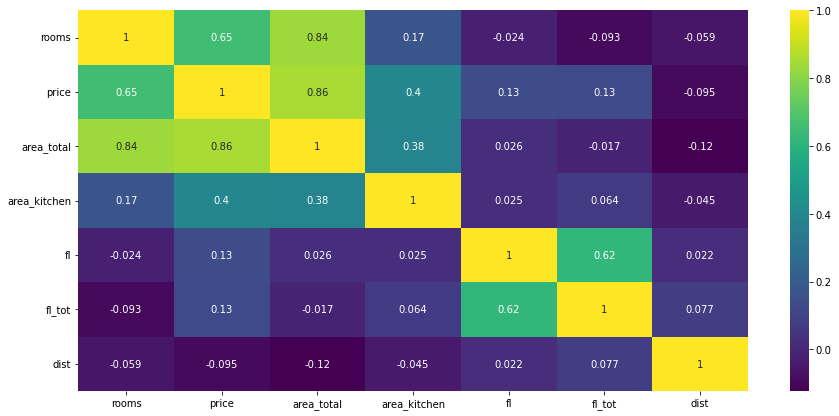

In [215]:
# тепловая карта признаков
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

In [ ]:
# как и ожидалось, кол-во комнат и площадь коррелируют с ценой сильно

In [ ]:
# всего у меня 6 признаков (кол-во комнат, площадь общая, площадь кухни, этаж, число этажей, район)
# категориальные - район, этаж, кол-во этажей, числовые - число комнат, площади (общая и кухни)

In [216]:
#в итоге это мои данные
df.head(1)

,rooms,price,area_total,area_kitchen,fl,fl_tot,dist
0,1,1450000.0,31.6,6.0,4,5,2


In [217]:
# первое - линейная регрессия, с one-hot представлением, в лоб
y = df['price']
X = df.iloc[:, [0,2,3,4,5,6]]
cat_feats = ['dist','fl','fl_tot']
num_feats = ['area_total','area_kitchen','rooms']
pre_cat = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ("cat", OneHotEncoder(), cat_feats)]).fit(X)

X = pre_cat.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
lin_reg = LinearRegression()
lr_mod = lin_reg.fit(X_train,y_train)
print('Linear Regression')
print('r2:', r2_score(y_test,lr_mod.predict(X_test)))
print('cross_val:', cross_val_score(lr_mod,X,y,cv=5, scoring='r2').mean())

Linear Regression
r2: 0.7920109972110118
cross_val: 0.7362672851249782


In [ ]:
# если разбивать трейн и тест без заданного random_state, то в тестовую и трейновую выборку попадают и точки, которые хорошо
# описываются моделью, и точки, которые плохо описываются, из-за этого при каждом запуске получается разный скор

In [218]:
# следующий catboost - он нативно умеет работать с категориальными признаками
y = df['price']
X = df.iloc[:, [0,2,3,4,5,6]]
cat_feats = ['dist','fl','fl_tot']
num_feats = ['area_total','area_kitchen','rooms']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

params = {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators':150}
cat_reg = CatBoostRegressor(silent=True, **params).fit(X_train,y_train, cat_features=cat_feats)

print('Catboost')
print('r2:', r2_score(y_test, cat_reg.predict(X_test)))
print('cross_val:', cross_val_score(cat_reg, X, y, cv=5).mean())

Catboost
r2: 0.7394963886908982
cross_val: 0.7146975931995607


In [161]:
# попробуем подобрать лучшие значения
from catboost import Pool
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
data_cat = Pool(X, y, cat_features=cat_feats)
params = {'learning_rate':[0.2,0.3,0.4],
          'max_depth':[3,4,5],
          'l2_leaf_reg': [6,7,8],
          'n_estimators':[200,300,400]}
cb_model = CatBoostRegressor(silent=True)
grid_found = cb_model.grid_search(params,data_cat,cv=5,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 619340.9786
bestIteration = 196

0:	loss: 619340.9786468	best: 619340.9786468 (0)	total: 3.23s	remaining: 4m 18s

bestTest = 601325.0738
bestIteration = 193

1:	loss: 601325.0737553	best: 601325.0737553 (1)	total: 6.83s	remaining: 4m 30s

bestTest = 596576.2893
bestIteration = 132

2:	loss: 596576.2892947	best: 596576.2892947 (2)	total: 9.89s	remaining: 4m 17s

bestTest = 619832.8834
bestIteration = 167

3:	loss: 619832.8834420	best: 596576.2892947 (2)	total: 14s	remaining: 4m 29s

bestTest = 603819.9547
bestIteration = 166

4:	loss: 603819.9547454	best: 596576.2892947 (2)	total: 18.2s	remaining: 4m 37s

bestTest = 579668.6817
bestIteration = 199

5:	loss: 579668.6817383	best: 579668.6817383 (5)	total: 22.2s	remaining: 4m 37s

bestTest = 604637.2449
bestIteration = 187

6:	loss: 604637.2449024	best: 579668.6817383 (5)	total: 26s	remaining: 4m 34s

bestTest = 586332.6361
bestIteration = 190

7:	loss: 586332.6360534	best: 579668.6817383 (5)	total: 29.7s	remaining: 4m 31s

bes


bestTest = 592068.7546
bestIteration = 268

65:	loss: 592068.7546023	best: 568002.8985321 (23)	total: 7m 45s	remaining: 1m 45s

bestTest = 606355.232
bestIteration = 296

66:	loss: 606355.2319998	best: 568002.8985321 (23)	total: 7m 55s	remaining: 1m 39s

bestTest = 599379.5212
bestIteration = 125

67:	loss: 599379.5212086	best: 568002.8985321 (23)	total: 8m 3s	remaining: 1m 32s

bestTest = 601511.4928
bestIteration = 138

68:	loss: 601511.4927976	best: 568002.8985321 (23)	total: 8m 13s	remaining: 1m 25s

bestTest = 596862.3953
bestIteration = 282

69:	loss: 596862.3952824	best: 568002.8985321 (23)	total: 8m 23s	remaining: 1m 19s

bestTest = 597504.6835
bestIteration = 252

70:	loss: 597504.6835446	best: 568002.8985321 (23)	total: 8m 32s	remaining: 1m 12s

bestTest = 568887.0083
bestIteration = 129

71:	loss: 568887.0083049	best: 568002.8985321 (23)	total: 8m 43s	remaining: 1m 5s

bestTest = 602497.142
bestIteration = 362

72:	loss: 602497.1419857	best: 568002.8985321 (23)	total: 8m 56

In [162]:
print(params)
print(grid_found['params'])

{'learning_rate': [0.2, 0.3, 0.4], 'depth': [3, 4, 5], 'l2_leaf_reg': [6, 7, 8], 'iterations': [200, 300, 400]}
{'depth': 3, 'l2_leaf_reg': 7, 'iterations': 400, 'learning_rate': 0.4}


In [163]:
r2_score(y_test,cb_model.predict(X_test))

0.8278031628753153

In [ ]:
# catboost все время пытается переобучиться, подбирает минимальную глубину дерева и максимальное число деревьев, так себе

In [158]:
# попробую XGBoost, для этого тоже нужно сделать one-hot
import xgboost as xgb
y = df['price']
X = df.iloc[:, [0,2,3,4,5,6]]
cat_feats = ['dist','fl','fl_tot']
num_feats = ['area_total','area_kitchen','rooms']
pre_cat = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ("cat", OneHotEncoder(), cat_feats)]).fit(X)

X = pre_cat.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
params = {'n_estimators':150, 'max_depth':5, 'learning_rate':0.05}
xgb_model = xgb.XGBRegressor(**params).fit(X_train,y_train)
print('XGBoost')
print('r2:', xgb_model.score(X_test,y_test))
print('cross_val:', cross_val_score(xgb_model, X,y, cv=5).mean())

XGBoost
r2: 0.7835110594961439
cross_val: 0.7152184230971323


In [142]:
# поищем с помощью grid-search 
parameters = {
    'max_depth': range (3, 10, 2),
    'n_estimators': range(50, 300, 50),
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=parameters,
    scoring = 'r2',
    n_jobs = -1,
    cv = 5,
    verbose=True
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [143]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [144]:
grid_search.best_score_

0.7206721631707891

In [89]:
# буду всё-таки использовать xgboost, но перед его использованием обучу его на всём датасете, чтобы получить больше информации
y = df['price']
X = df.iloc[:, [0,2,3,4,5,6]]
cat_feats = [5,3,4]
num_feats = [1,2,0]
pre_cat = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_feats),
        ("cat", OneHotEncoder(), cat_feats)]).fit(X)

X_transf = pre_cat.transform(X)

params = {'n_estimators':150, 'max_depth':5, 'learning_rate':0.05}
xgb_model = xgb.XGBRegressor(**params).fit(X_transf,y)
xgb_model.score(X_transf, y)

0.9104395106257723

In [ ]:
# естесственно, свой датасет он запоминает неплохо

In [90]:
# сохраню трансформер и модель
import pickle
with open('col_transf.pkl', 'wb') as ct:
    pickle.dump(pre_cat, ct)

xgb_model.save_model('xgb_trained')